In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import seaborn as sns
from random import randrange
from itertools import combinations_with_replacement
sns.set()
df = pd.read_csv('TempLinkoping2016.csv')
df.head()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,time,temp
0,0.002732,0.1
1,0.005464,-4.5
2,0.008197,-6.3
3,0.010929,-9.6
4,0.013661,-9.9


In [2]:
X = df.iloc[:, 0:1].values
Y = df.iloc[:, 1].values
n_features = X.shape[1]
degree = 15
combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
flat_combs = [item for sublist in combs for item in sublist]
X_new = np.empty((X.shape[0], len(flat_combs)))
for i, index_combs in enumerate(flat_combs):
    X_new[:, i] = np.prod(X[:, index_combs], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size = 0.2)

In [3]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 64):
        self.W1 = np.random.randn(X_new.shape[1], 1) / np.sqrt(X.shape[1])
        self.fitness = 0
        self.id = id_

def feed_forward(X, nets):
    return np.dot(X, nets.W1)

In [4]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[0]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[cutoff:, :] = parent2.W1[cutoff:, :].copy()
        child2.W1[cutoff:, :] = parent1.W1[cutoff:, :].copy()
        return child1, child2
        
    def calculate_fitness(self, X, Y):
        for i in range(self.population_size):
            logits = feed_forward(X, self.population[i])
            self.population[i].fitness = np.mean(np.square(Y - logits))
        
    def evolve(self, X, Y, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness(X, Y)
            sort_fitness = np.argsort([i.fitness for i in self.population])
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          self.population[0].fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([i.fitness for i in self.population])
            parent_probabilities = [i.fitness / total_fitness for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [6]:
population_size = 100
generations = 1000
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork)

In [7]:
fittest_nets = neural_evolve.evolve(X_train, Y_train, generations, 100)

epoch 100, fittest individual 0 with accuracy 63.516063
epoch 200, fittest individual 0 with accuracy 63.516037
epoch 300, fittest individual 0 with accuracy 63.515969
epoch 400, fittest individual 0 with accuracy 63.515947
epoch 500, fittest individual 0 with accuracy 63.515944
epoch 600, fittest individual 0 with accuracy 63.515944
epoch 700, fittest individual 0 with accuracy 63.515944
epoch 800, fittest individual 0 with accuracy 63.515944
epoch 900, fittest individual 0 with accuracy 63.515944
epoch 1000, fittest individual 0 with accuracy 63.515939


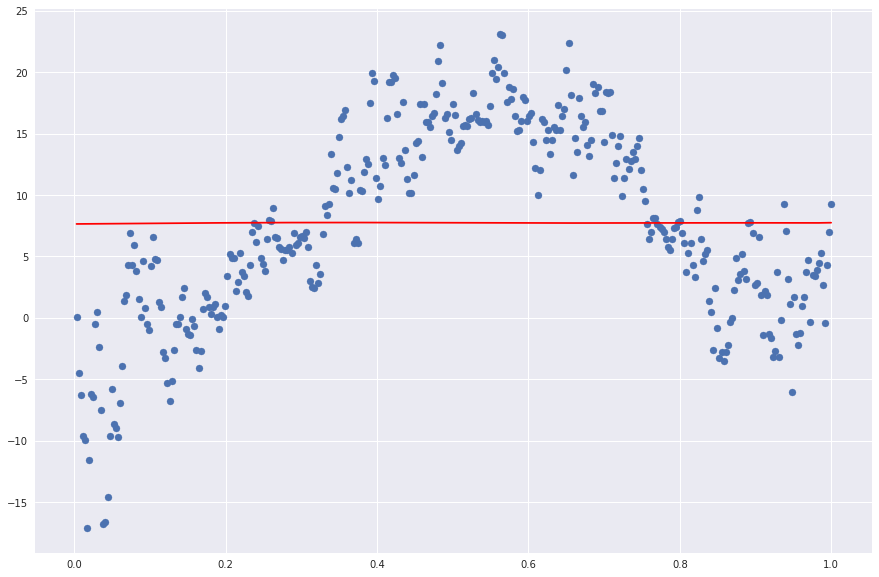

In [8]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:,0],Y)
plt.plot(X,feed_forward(X_new,fittest_nets), c='red')
plt.show()